In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.optimize import minimize, rosen, rosen_der,root
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


from src import utils

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
torch.cuda.is_available()

True

In [4]:
np.random.seed(0)

n = 20
num_trials = 100
g = 1.3

T_max = 100
num_steps = 20000
dt = T_max/num_steps
ts = np.linspace(0,T_max,num_steps)
u = np.zeros((n,num_steps))
B = np.zeros((n,n))


W = utils.create_random_weight_matrix(n = n, scale = g)

init_scale = 1

In [5]:
x = np.random.uniform(-1,1,(n,num_trials))

xs = np.zeros((n,num_trials,num_steps))

#Euler integrate
for step in range(num_steps):
  x += dt*utils.RNN_update(x,W)
  xs[:,:,step] = x

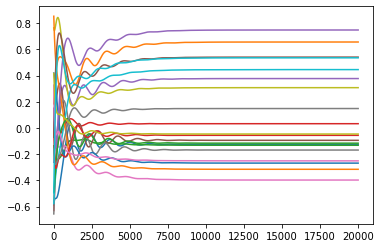

In [6]:
plt.plot(xs[:,0,:].T);

In [7]:
x0_guess = xs[:,3,-1]
sol = root(fun = utils.RNN_update, x0 = x0_guess, jac=utils.RNN_update_jac, method='hybr',args = (W))
x_star = sol.x

J_star = utils.RNN_update_jac(sol.x,W)
utils.check_linear_stability(J_star)


'Matrix is linearly stable.'

In [117]:
M = utils.get_local_lyapunov_metric(J = J_star)

num_test_points = 10000

x_test_points = np.random.uniform(-1/n,1/n,(n,num_test_points))
y_test_points = x_test_points - np.expand_dims(x_star,1)
V_I = utils.V(M = M,Q = np.eye(n),x = y_test_points)

V_dot_I = utils.V_dot(M = M,W = W, Q = np.eye(n),x = y_test_points)

In [118]:
#Uses the sampling method of (Najevi et al, 2016) to find critical boundry of ellipse. 
c = np.inf
for i in range(num_test_points):
    if V_dot_I[i] >= 0 and V_I[i] < c:
        c = V_I[i]

c



8.134765807474746

In [119]:
xs_flattened = np.reshape(xs, newshape = (n,num_trials*num_steps))
#pca = PCA(n_components=3)
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)

xs_flattened_svd= svd.fit_transform(xs_flattened.T)

Q = svd.components_



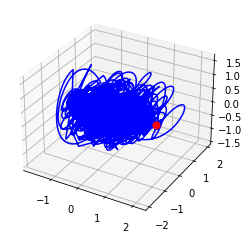

In [120]:
fig = plt.figure()
ax = plt.axes(projection='3d')

#xs_flattened_projection = (Q @ xs_flattened).T

ax.plot(xs_flattened_svd[:,0],xs_flattened_svd[:,1],xs_flattened_svd[:,2],color = 'b')

#ax.plot(xs_flattened_projection[:,0],xs_flattened_projection[:,1],xs_flattened_projection[:,2],color = 'g')

x_star_pca = Q @ x_star

ax.scatter(x_star_pca[0],x_star_pca[1],x_star_pca[2],c = 'r',s = 50)



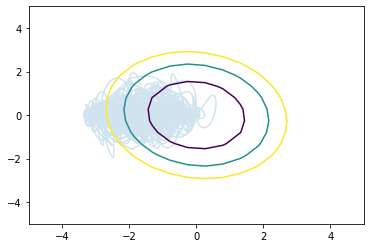

In [123]:
center = x_star_pca[0]

plt.plot(xs_flattened_svd[:,0] - x_star_pca[0] ,xs_flattened_svd[:,1]- x_star_pca[1],alpha = 0.2)

#what is the projection of an ellipse?
num_points = 20
x_1 = np.linspace(-5, 5, num_points)# + center[0,:]
#x_2 = x.reshape(-1, 1)# + center[1,:]

X1_mesh, X2_mesh = np.meshgrid(x_1, x_1)

Y =  np.vstack([X1_mesh.flatten(), X2_mesh.flatten()])

h = utils.V_y(M,Q[:2,:],Y,num_points)

#A = Q[:2,:] @ M @ Q[:2,:].T

#f_x = np.dot(np.dot(Y.T, A), Y)
#f_x = np.diag(f_x).reshape(num_points, num_points)

#f_x = np.diag(f_x).reshape(n_points, n_points)
#Q[:2,:] @ M @ Q[:2,:].T
cs = plt.contour(X1_mesh,X2_mesh,h,levels = [c, c+10,c+20])#,colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')